In [5]:
import os
import csv
import nltk
import re
import operator
import math
import readability
import random
from nltk import word_tokenize
from gensim.models import Word2Vec
from numpy import array
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from numpy import array
from numpy import mean
from numpy import zeros
from nltk.tag import StanfordPOSTagger
from nltk.tag import StanfordNERTagger

java_path = "C:/Program Files/Java/jdk1.8.0_144/bin"
os.environ['JAVAHOME'] = java_path

nltk.internals.config_java("C:/Program Files/Java/jdk1.8.0_144/bin", options='-Xmx3024m')
st = StanfordPOSTagger('english-left3words-distsim.tagger', path_to_jar='stanford-postagger.jar')
ner = StanfordNERTagger('english.all.3class.distsim.crf.ser.gz', 'stanford-ner.jar')

def train_test_split(directory):
    file_names = os.listdir(directory)
    random.shuffle(file_names)
    train_list = []
    test_list = []
    i = 0
    for file_name in file_names:
        if file_name != '.DS_Store':
            if i < 4:
                train_list.append(file_name)
                i+= 1
            else:
                test_list.append(file_name)
                i = 0
    return (train_list, test_list)

def make_training_dicts(filepath, file_list):
    age_dir = {}
    time_dir = {}
    with open(filepath, encoding='latin-1') as file:
        reader = csv.reader(file)
        for row in reader:
            if row[0] in file_list:
                age_dir[row[0]] = row[1]
                time_dir[row[0]] = row[2]
    return (age_dir, time_dir)

def clean_and_tokenize_file(file_name):
    file = open(file_name, encoding='latin-1')
    raw_text = file.read()
    raw_text_lower = raw_text.lower()
    caseless_tokens = nltk.word_tokenize(raw_text_lower)
    caseless_tokens = [x for x in caseless_tokens if re.match('\w+', x)]
    sentences = nltk.sent_tokenize(raw_text_lower)
    raw_sentence_tokens = nltk.sent_tokenize(raw_text)
    case_tokens = nltk.word_tokenize(raw_text)
    sentence_list = []
    for sentence in sentences:
        words = nltk.word_tokenize(sentence)
        sentence_list.append([x for x in words if re.match('\w+', x)])
    return (caseless_tokens, sentence_list, raw_sentence_tokens, case_tokens)


def clean_and_tokenize_corpus(directory, file_list):
    file_dir = {}
    for file_name in os.listdir(directory):
        if file_name in file_list:
            file_dir[file_name] = clean_and_tokenize_file(directory + file_name)
    return file_dir


def count_total_vocab(file_wordfreqs):
    vocab = {}
    for words in file_wordfreqs:
        for word in words:
            if word in vocab:
                vocab[word] += 1
            else:
                vocab[word] = 1
    return vocab

def get_corpus_vocab(corpus, unknown_threshold):
    initial_dict = count_total_vocab(corpus)
    sorted_dict = sorted(initial_dict.items(), key=operator.itemgetter(1), reverse=True)
    filtered_dict = [key for key, value in sorted_dict[:unknown_threshold]]
    return filtered_dict

def get_idf_dict(vocab, corpus):
    idf_dict = {}
    num_docs = len(corpus) 
    for word in vocab:
        df_count = 1
        for doc in corpus:
            if word in doc:
                df_count += 1
        idf_dict[word] = math.log(num_docs / df_count)
    return idf_dict

def get_named_entities(novel):
    named_entities = ner.tag(novel)
    entities = []
    cur_entity = []
    last_tag = 'O'
    for entity in named_entities:
        if entity[1] == 'O':
            if len(cur_entity) > 0:
                new_entry = (' '.join(cur_entity), last_tag)
                if new_entry not in entities:
                    entities.append(new_entry)
                cur_entity = []
            last_tag = 'O'
        elif entity[1] == last_tag:
            cur_entity.append(entity[0])
        else:
            if len(cur_entity) > 0:
                new_entry = (' '.join(cur_entity), last_tag)
                if new_entry not in entities:
                    entities.append(new_entry)
                cur_entity = []
            cur_entity.append(entity[0])
            last_tag = entity[1]
    return entities

def get_ne_corpus(corpus):
    ne_dict = {}
    for key, value in corpus.items():
        ne_dict[key] = get_named_entities(value[3])
    return ne_dict

full_list = train_test_split('backup_plan')
train_list = full_list[0]
test_list = full_list[1]
training_data = make_training_dicts('backup.csv', train_list)
training_age = training_data[0]
training_time = training_data[1]
corpus = clean_and_tokenize_corpus('backup_plan/', train_list)
ugram_corpus = [value[0] for key, value in corpus.items()]
vocab = get_corpus_vocab(ugram_corpus, 500)
idf_dict = get_idf_dict(vocab, ugram_corpus)
ne_corpus = get_ne_corpus(corpus)
ne_vals = [value for key, value in ne_corpus.items()]
ne_vocab = get_corpus_vocab(ne_vals, 100)
ne_idf_dict = get_idf_dict(ne_vocab, ne_vals)


testing_data = make_training_dicts('backup.csv', test_list)
testing_age = testing_data[0]
testing_time = testing_data[1]
test_corpus = clean_and_tokenize_corpus('backup_plan/', test_list)
test_ugram_corpus = [value[0] for key, value in test_corpus.items()]
test_idf_dict = get_idf_dict(vocab, test_ugram_corpus)
test_ne_corpus = get_ne_corpus(test_corpus)
test_ne_vals = [value for key, value in test_ne_corpus.items()]
test_ne_idf_dict = get_idf_dict(ne_vocab, test_ne_vals)

In [6]:
def train_word2vec(corpus):
    model = Word2Vec(corpus, size=100)
    model.train(corpus, total_examples=len(corpus), epochs=50)
    return model

word2vec = train_word2vec(ugram_corpus)


In [7]:
st = StanfordPOSTagger('english-left3words-distsim.tagger', path_to_jar='stanford-postagger.jar')
st.java_options = '-mx4g'
def clean_and_tokenize_file(file_name):
    file = open(file_name)
    raw_text = file.read()
    raw_text_lower = raw_text.lower()
    caseless_tokens = nltk.word_tokenize(raw_text_lower)
    sentences = nltk.sent_tokenize(raw_text_lower)
    raw_sentence_tokens = nltk.sent_tokenize(raw_text)
    case_tokens = nltk.word_tokenize(raw_text)
    sentence_list = []
    for sentence in sentences:
        words = nltk.word_tokenize(sentence)
        sentence_list.append([x for x in words if re.match('\w+', x)])
    return (caseless_tokens, sentence_list, raw_sentence_tokens, case_tokens)

def tf_idf(vocab, document, idf_dict):
    counts = Counter(document)
    doc_len = len(document)
    tf_idfs = []
    for word in vocab:
        doc_counter = 0
        tf = counts[word] / len(document)
        idf = idf_dict[word]
        tf_idfs.append(tf*idf)
    return tf_idfs

def get_avg_word2vec(novel):
    vec_list = []
    for word in novel:
        if word in word2vec:
            vec_list.append(word2vec[word])
    vector_array = array(vec_list)
    vector_array = mean(vector_array, axis=0)
    return vector_array.tolist()

def get_pairwise_similarity(sentences):
    sentence_vectors = []
    for sentence in sentences:
        vec_list = []
        for word in sentence:
            if word in word2vec:
                vec_list.append(word2vec[word])
        if len(vec_list) > 0:
            vector_array = array(vec_list)
            vector_array = mean(vector_array, axis=0)
            sentence_vectors.append(vector_array)
    cs_sim = cosine_similarity(sentence_vectors, sentence_vectors)
    return mean(cs_sim)

def get_pos_vector(novel, pos_tags):
    tagged_tokens = st.tag(novel)
    tags = [tag for (word, tag) in tagged_tokens]
    num_tokens = len(novel)
    pos_vector = [tags.count(pos_tag) / num_tokens for pos_tag in pos_tags]
    return pos_vector

def get_readability_score(sentences):
    newline_regex = re.compile(r'\n')
    clean_sents = []
    for sentence in sentences:
        clean_sents.append(re.sub(newline_regex, ' ', sentence))
    readability_text = '\n'.join(clean_sents)
    readability_results = readability.getmeasures(readability_text, lang='en')
    flesch_score = readability_results['readability grades']['FleschReadingEase']   
    return flesch_score

def feature_vector(novel, vocab, idf_dict, pos_tags):
    tokens = novel[0] # for unigrams
    token_sents = novel[1] #  for sent similarity
    case_tokens = novel[3] # for pos tagging and ner
    
    unigram_vector = tf_idf(vocab, tokens, idf_dict)
    pos_vector = get_pos_vector(case_tokens, pos_tags)
    word_2_vec_vector = get_avg_word2vec(tokens)
    word_vector = unigram_vector + pos_vector + word_2_vec_vector
    
    # gets ratio of unique words to total # of words
    novel_vocab = count_total_vocab([tokens])
    vocab_size = len(novel_vocab) / len(tokens)
    word_vector.append(vocab_size)
      
    cs_similarity = get_pairwise_similarity(token_sents)
    word_vector.append(cs_similarity)
    return word_vector

def feature_vector_time_period(age_vector, novel, ne_vocab, ne_novel, ne_idf_dict):
    raw_sents = novel[2]
    ne_vector = tf_idf(ne_vocab, ne_novel, ne_idf_dict)
    time_period_vector = age_vector.tolist() + ne_vector
    time_period_vector.append(get_readability_score(raw_sents))
    return time_period_vector

def create_age_vector_arrays(training_data, corpus, vocab, idf_dict, pos_tags):
    len_feature_vector = len(vocab) + len(pos_tags) + 102
    vector_array = zeros((len(training_data), len_feature_vector))
    results_array = zeros(len(training_data))
    index = 0
    for data, age in training_data.items():
        results_array[index] = age
        novel = corpus[data]
        vector_array[index] = feature_vector(novel, vocab, idf_dict, pos_tags)
        index += 1
    return (vector_array, results_array)

def create_time_vector_arrays(training_data, age_arrays, corpus, ner_vocab, ner_corpus, ner_idf_dict):
    len_feature_vector = len(age_arrays[0]) + len(ner_vocab) + 1
    vector_array = zeros((len(training_data), len_feature_vector))
    results_array = zeros(len(training_data))
    index = 0
    for data, time in training_data.items():
        results_array[index] = time
        novel = corpus[data]
        age_vector = age_arrays[index]
        vector_array[index] = feature_vector_time_period(age_vector, novel, ner_vocab, ner_corpus[data], ner_idf_dict)
        index += 1
    return (vector_array, results_array)
       
tagset = ['CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS', 'NNP', 'NNPS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB']
training_data_age = create_age_vector_arrays(training_age, corpus, vocab, idf_dict, tagset)
training_data_time = create_time_vector_arrays(training_time, training_data_age[0], corpus, ne_vocab, ne_corpus, ne_idf_dict)
testing_data_age = create_age_vector_arrays(testing_age, test_corpus, vocab, test_idf_dict, tagset)
testing_data_time = create_time_vector_arrays(testing_time, testing_data_age[0], test_corpus, ne_vocab, test_ne_corpus, test_ne_idf_dict)


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:43: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `__g

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:43: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:43: DeprecationWarning: Call to deprecated `__g

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:43: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `__g

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:43: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:43: DeprecationWarning: Call to deprecated `__g

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:43: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `__g

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:43: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:43: DeprecationWarning: Call to deprecated `__g

array([-1.35475655e-02, -8.29241177e-03, -6.81639734e-03, -6.64981303e-03,
       -4.35540478e-03, -3.01885628e-03, -3.59318473e-03, -2.18399773e-03,
       -2.53072553e-03, -2.90554021e-03, -2.55203282e-03, -1.90700289e-03,
       -2.16656449e-03, -2.09005193e-03, -2.17043854e-03, -1.36754093e-03,
       -1.65325238e-03, -1.79174980e-03, -1.43049430e-03, -1.60773225e-03,
       -2.10942219e-03, -1.50603834e-03, -1.34235958e-03, -1.38981674e-03,
       -1.42952578e-03, -1.25035080e-03, -1.31233566e-03, -1.25906743e-03,
       -8.60039903e-04, -7.70936670e-04, -1.09345163e-03, -1.02565570e-03,
       -1.50991240e-03, -9.89820699e-04, -9.99505833e-04, -1.12444406e-03,
       -8.76504631e-04, -7.26385053e-04, -6.63431682e-04, -6.37281820e-04,
       -6.48903981e-04, -9.21056247e-04, -6.49872494e-04, -7.65125589e-04,
       -6.01446824e-04, -6.45998441e-04, -6.64400195e-04, -5.77233989e-04,
       -5.61737774e-04,  3.80873241e-03, -5.56895207e-04, -5.57863721e-04,
       -4.36799545e-04, -

## Neural Network

In [9]:
from math import floor
from statistics import mean
from numpy import array
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

# Function to scale input vectors
def scale(scaler, input_vector):
    scaler.fit(input_vector)
    scaled_features = scaler.transform(input_vector)
    return scaled_features

# Function to calculate number of nodes in hidden layer of MLP
def calc_node_num(input_len, output_len):
    return floor(mean([input_len, output_len]))

# Function to construct params dictionary to pass to cross validation
def construct_params(node_num):
    return {'hidden_layer_sizes': [(node_num,)], 
            'activation': ['logistic', 'tanh', 'relu'],
            'solver': ['lbfgs', 'sgd']}

# Function to run 5-fold cross validation (with MLP) to determine optimal hyperparameters for MLP classifer
def cross_validation(x_features, y_labels, params):
    clf = GridSearchCV(MLPClassifier(), params, cv=5,
                       scoring='accuracy') # Determine why F1 score was not working earlier
    clf.fit(x_features, y_labels)
    return clf.best_params_

# Return model with given params
def get_model(params):
    return MLPClassifier(hidden_layer_sizes=params['hidden_layer_sizes'], 
                         activation=params['activation'], 
                         solver=params['solver'])

# Train model on entire training set
def train_model(model, x_vector, y_vector):
    model.fit(x_vector, y_vector)
    return model

# Steps for age and time period classifiers
# (0) Scale input/output data (?)
scaler = StandardScaler()
age_features = training_data_age[0]
age_labels = training_data_age[1]
scaled_age_features = scale(scaler, age_features)
# print(scaled_age_features)

time_period_features = training_data_time[0]
time_period_labels = training_data_time[1]
scaled_time_period_features = scale(scaler, time_period_features)
# print(scaled_time_period_features)

# (1) Perform cross validation with all chosen parameters
age_node_num = calc_node_num(len(age_features[0]), len(age_labels))
age_params = construct_params(age_node_num)
best_age_params = cross_validation(scaled_age_features, age_labels, age_params)

tp_node_num = calc_node_num(len(time_period_features[0]), len(time_period_labels))
time_period_params = construct_params(tp_node_num)
best_tp_params = cross_validation(scaled_time_period_features, time_period_labels, time_period_params)

# (2) After determining optimal params based on accuracy, retrain model with those params
age_model = get_model(best_age_params)
trained_age_model = train_model(age_model, scaled_age_features, age_labels)
tp_model = get_model(best_tp_params)
trained_tp_model = train_model(tp_model, scaled_time_period_features, time_period_labels)

C:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda\lib

C:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## Metrics

AGE CALCULATIONS
TIME PERIOD CALCULATIONS
RANDOM CALCULATIONS


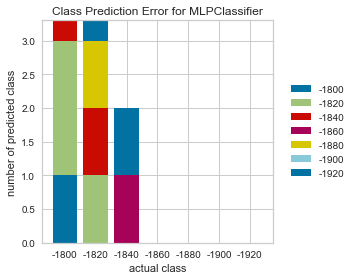

C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


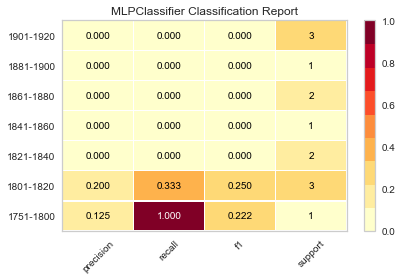

-0.09412955465587046
FINAL CALCULATIONS


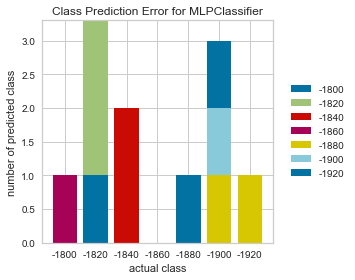

C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


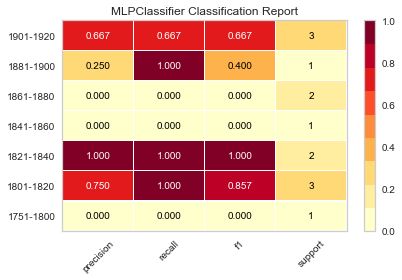

-0.012145748987854251


In [73]:
from random import randint
from yellowbrick.classifier import ClassPredictionError, ClassificationReport
from numpy import append

# Function to predict labels for given test set and print classification report of precision, recall and F1
def find_avg_goodness(model, test_features, test_labels, class_diff_dict):
    predictions = model.predict(test_features)
    sum = 0
    for i in range(len(predictions)):
        sum += goodness(predictions[i], test_labels[i], class_diff_dict[predictions[i]])
    
    print(sum / len(predictions))
#     print(classification_report(test_labels, predictions, target_names=target_name))
    
# Function to produce visualization of class prediction
def predict_class_error(best_params, training_features, training_labels, test_features, test_labels, class_labels):
    model = get_model(best_params)
    visualizer = ClassPredictionError(model, classes=class_labels)
    visualizer.fit(training_features, training_labels)
    visualizer.score(test_features, test_labels)
    g = visualizer.poof()
    
# Function to produce visualization of metrics
def predict_metrics(best_params, training_features, training_labels, test_features, test_labels, class_labels):
    model = get_model(best_params)
    visualizer = ClassificationReport(model, classes=class_labels, support=True)
    visualizer.fit(training_features, training_labels)
    visualizer.score(test_features, test_labels)
    g = visualizer.poof()
        
# Function to provide baseline metrics (with no neural network) based on random assignment of class
def produce_random_classification(model, training_features, max_classes):
    random_predictions = []
    random_features = []
    for sample in training_features:
        random_int = randint(0, max_classes - 1)
        random_predictions.append(random_int)
        random_features.append([random_int] * len(training_features[0]))
    return (random_features, random_predictions)
    
# Function to define metric for model accuracy
def goodness(predicted, actual, range_size):
    return float((predicted - actual)) / float(range_size)

# (3) Use test set to return precision, recall, and f1 scores
print("AGE CALCULATIONS")
# age_classes = ["18-24", "25-34", "35-49", "50-64", "65-x"]
# test_age_features = testing_data_age[0]
# test_age_features = append(test_age_features, [test_age_features[0]], axis=0)
# test_age_labels = testing_data_age[1]
# test_age_labels = append(test_age_labels, 4)
# scaled_test_age_features = scale(scaler, test_age_features)

# print("RANDOM CALCULATIONS")
# random_vals = produce_random_classification(age_model, scaled_age_features, 5)
# random_features = random_vals[0]
# random_targets = random_vals[1]
# predict_class_error(best_age_params, random_features, random_targets, 
#                     scaled_test_age_features, test_age_labels, age_classes)
# predict_metrics(best_age_params, random_features, random_targets, 
#                     scaled_test_age_features, test_age_labels, age_classes)
# age_range_dict = {0: 6, 1: 9, 2: 14, 3: 14, 4: 1}
# find_avg_goodness(trained_age_model, random_features, random_targets, age_range_dict)

# print("FINAL CALCULATIONS")
# predict_class_error(best_age_params, scaled_age_features, age_labels, 
#                     scaled_test_age_features, test_age_labels, age_classes)
# predict_metrics(best_age_params, scaled_age_features, age_labels, 
#                     scaled_test_age_features, test_age_labels, age_classes)
# find_avg_goodness(trained_age_model, scaled_test_age_features, test_age_labels, age_range_dict)

print("TIME PERIOD CALCULATIONS")
tp_classes = ["1751-1800", "1801-1820", "1821-1840", "1841-1860", "1861-1880", "1881-1900", "1901-1920"]
test_tp_features = testing_data_time[0]
test_tp_features = append(test_tp_features, [test_tp_features[0]], axis=0)
test_tp_labels = testing_data_time[1]
test_tp_labels = append(test_tp_labels, 0)
scaled_test_tp_features = scale(scaler, test_tp_features)

print("RANDOM CALCULATIONS")
random_vals = produce_random_classification(tp_model, scaled_time_period_features, 7)
random_features = random_vals[0]
random_targets = random_vals[1]
predict_class_error(best_tp_params, random_features, random_targets, 
                    scaled_test_tp_features, test_tp_labels, ["-1800", "-1820", "-1840", "-1860", "-1880", "-1900", "-1920"])
predict_metrics(best_tp_params, random_features, random_targets, 
                    scaled_test_tp_features, test_tp_labels, tp_classes)
tp_range_dict = {0: 49, 1: 19, 2: 19, 3: 19, 4: 19, 5: 19, 6: 19}
find_avg_goodness(trained_tp_model, random_features, random_targets, tp_range_dict)

print("FINAL CALCULATIONS")
predict_class_error(best_tp_params, scaled_time_period_features, time_period_labels, 
                    scaled_test_tp_features, test_tp_labels, ["-1800", "-1820", "-1840", "-1860", "-1880", "-1900", "-1920"])
predict_metrics(best_tp_params, scaled_time_period_features, time_period_labels, 
                    scaled_test_tp_features, test_tp_labels, tp_classes)
find_avg_goodness(trained_tp_model, scaled_test_tp_features, test_tp_labels, tp_range_dict)